In [122]:
import xml.etree.ElementTree as ET
import pandas as pd
import geopy
import math
import matplotlib.pyplot as plt
from geopy.distance import distance

In [123]:
# Process the .gpx xml file

tree = ET.parse('GDMBR.gpx')
root = tree.getroot()

myList = []

for child in root[1][1]:
    
    lat = child.attrib['lat']
    lon = child.attrib['lon']
    ele = child[0].text
    
    myList.append([lat,lon,ele])
    
df = pd.DataFrame(myList, columns=['lat', 'lon', 'ele'])   

In [124]:
df[['lat_prev', 'lon_prev', 'ele_prev']] = df[['lat', 'lon', 'ele']].shift()

In [125]:
df = df.astype(float)

In [126]:
def dfDistance(row):
    
    if math.isnan(row['lat_prev']):
        return 0
    
    return distance((row['lat'],row['lon']),
                    (row['lat_prev'],row['lon_prev'])).kilometers


In [127]:
df['dist'] = df.apply(dfDistance, axis=1)
df = df[df['dist'] > 0]

# calculate the gradient between the points
df['eleDiff'] = df['ele'] - df['ele_prev']
df['grade'] = df['eleDiff']/(df['dist']*1000)

Remove points and recalculate metrics until there are no more erroneous grades.

In [128]:
badGrades = (len(df[abs(df['grade']) > .35]) >= 1)

while badGrades:
    
    print(len(df))
    
    df = df[(abs(df['grade']) < .35) | (df['grade'].isna())]
    
    df[['lat_prev', 'lon_prev', 'ele_prev']] = df[['lat', 'lon', 'ele']].shift()
    df['dist'] = df.apply(dfDistance, axis=1)

    # calculate the gradient between the points
    df['eleDiff'] = df['ele'] - df['ele_prev']
    df['grade'] = df['eleDiff']/(df['dist']*1000)
    
    badGrades = (len(df[abs(df['grade']) > .35]) >= 1)

18047
18011
18006
18003
18002


In [129]:
df['slope'] = np.arctan(df['grade'])

In [130]:
df

,lat,lon,ele,lat_prev,lon_prev,ele_prev,dist,eleDiff,grade,slope
1,51.160931,-115.559829,1406.765991,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,51.160872,-115.559809,1406.886963,51.160931,-115.559829,1406.765991,0.006711,0.120972,0.018025,0.018023
3,51.160814,-115.559683,1406.536011,51.160872,-115.559809,1406.886963,0.010924,-0.350952,-0.032128,-0.032116
4,51.160696,-115.559269,1405.836060,51.160814,-115.559683,1406.536011,0.031798,-0.699951,-0.022013,-0.022009
5,51.160490,-115.558975,1405.931030,51.160696,-115.559269,1405.836060,0.030793,0.094970,0.003084,0.003084
...,...,...,...,...,...,...,...,...,...,...
18046,31.353338,-108.531870,1423.000000,31.394864,-108.561707,1439.000000,5.408821,-16.000000,-0.002958,-0.002958
18047,31.350737,-108.531126,1422.000000,31.353338,-108.531870,1423.000000,0.296949,-1.000000,-0.003368,-0.003368
18048,31.335328,-108.531163,1418.000000,31.350737,-108.531126,1422.000000,1.708482,-4.000000,-0.002341,-0.002341
18049,31.333430,-108.530234,1419.000000,31.335328,-108.531163,1418.000000,0.228259,1.000000,0.004381,0.004381


In [131]:
calcDF = df[['dist','slope']].iloc[1:].copy()

<AxesSubplot:>

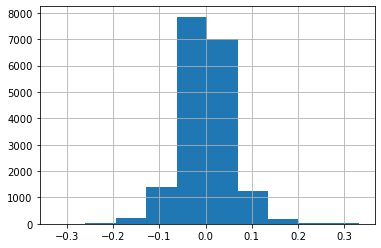

In [139]:
calcDF['slope'].hist()